In [1]:
# 1️⃣ Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 2️⃣ Load Dataset
data = pd.read_csv("/content/drive/MyDrive/Uber-Jan-Feb-FOIL.csv")
print("✅ Dataset Loaded Successfully!")
print(data.head())
print("\nDataset Info:")
print(data.info())


✅ Dataset Loaded Successfully!
  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB
None


In [4]:
data.head(5)

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [5]:
# 3️⃣ Data Preprocessing
# Convert Date/Time column if present
if 'Date/Time' in data.columns:
    data['Date/Time'] = pd.to_datetime(data['Date/Time'])
    data['Hour'] = data['Date/Time'].dt.hour
    data['Day'] = data['Date/Time'].dt.day
    data['DayOfWeek'] = data['Date/Time'].dt.dayofweek
    data['Month'] = data['Date/Time'].dt.month
elif 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data['Hour'] = data['date'].dt.hour
    data['Day'] = data['date'].dt.day
    data['DayOfWeek'] = data['date'].dt.dayofweek
    data['Month'] = data['date'].dt.month
else:
    print("⚠️ Date column not found. Please verify CSV headers.")

# Handle missing values
data = data.dropna()
print("\n✅ Missing values handled successfully!")


✅ Missing values handled successfully!


🔍 Starting Exploratory Data Analysis...


/tmp/ipython-input-1164009004.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DayOfWeek', data=data, palette="coolwarm")


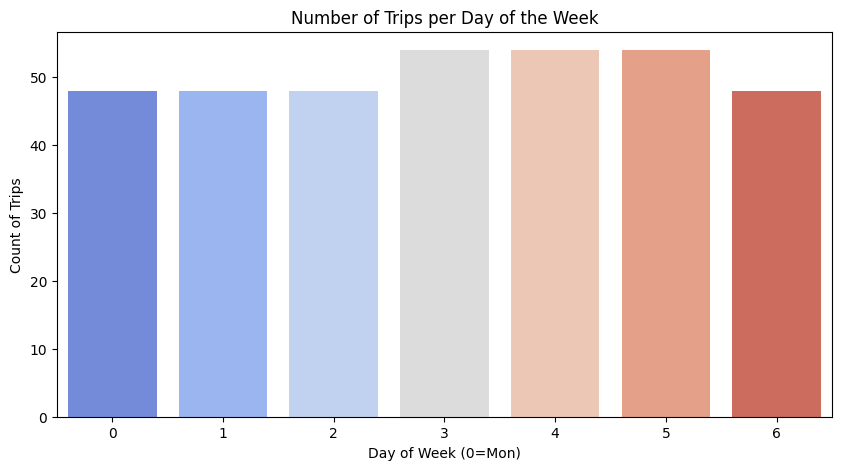

/tmp/ipython-input-1164009004.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=data, palette="viridis")


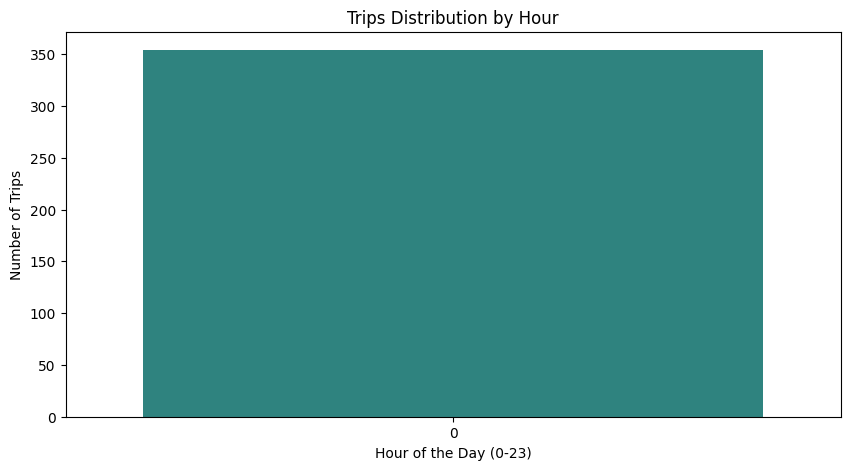

/tmp/ipython-input-1164009004.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=data, palette="mako")


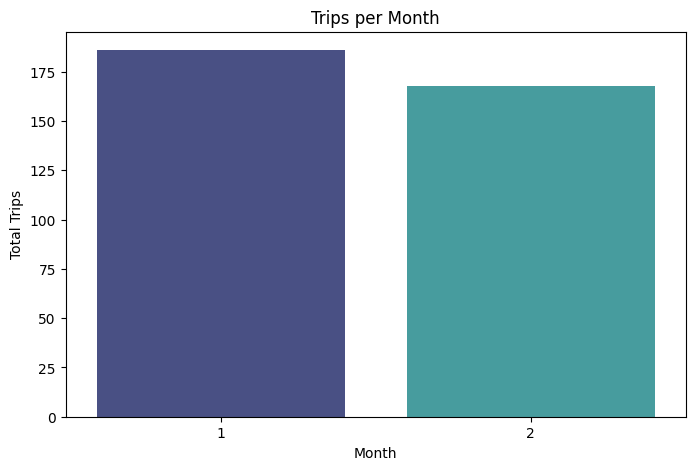

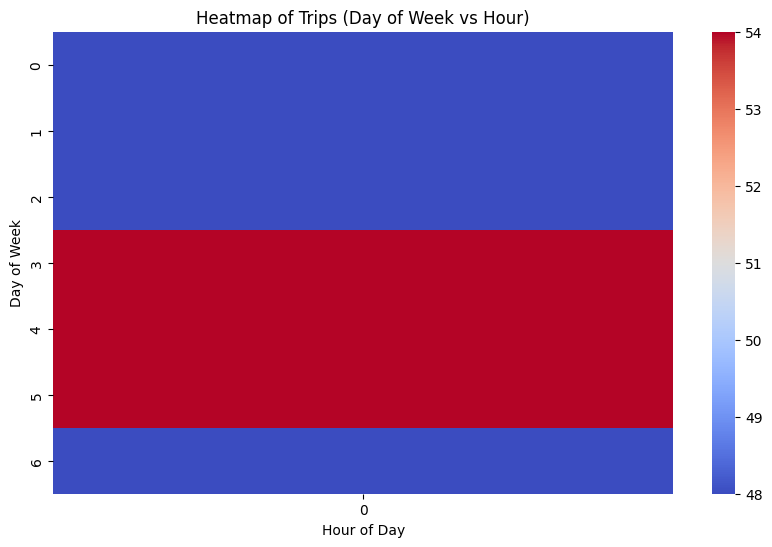

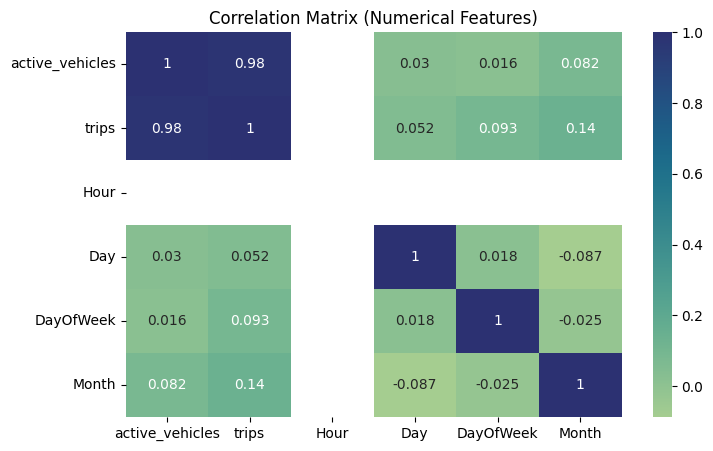

✅ EDA Completed Successfully!


In [13]:
# 4️⃣ EXPLORATORY DATA ANALYSIS (EDA)

print("🔍 Starting Exploratory Data Analysis...")

# 1. Number of trips per day of week
plt.figure(figsize=(10,5))
sns.countplot(x='DayOfWeek', data=data, palette="coolwarm")
plt.title("Number of Trips per Day of the Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Count of Trips")
plt.show()

# 2. Number of trips per hour
if 'Hour' in data.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x='Hour', data=data, palette="viridis")
    plt.title("Trips Distribution by Hour")
    plt.xlabel("Hour of the Day (0-23)")
    plt.ylabel("Number of Trips")
    plt.show()

# 3. Trips per Month (useful if data covers multiple months)
if 'Month' in data.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(x='Month', data=data, palette="mako")
    plt.title("Trips per Month")
    plt.xlabel("Month")
    plt.ylabel("Total Trips")
    plt.show()

# 4. Heatmap — hourly vs weekday demand pattern
if 'Hour' in data.columns and 'DayOfWeek' in data.columns:
    plt.figure(figsize=(10,6))
    heat_data = data.groupby(['DayOfWeek', 'Hour']).size().unstack()
    sns.heatmap(heat_data, cmap='coolwarm')
    plt.title("Heatmap of Trips (Day of Week vs Hour)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()

# 5. Base company distribution
if 'Base' in data.columns or 'Dispatching_base_num' in data.columns:
    base_col = 'Base' if 'Base' in data.columns else 'Dispatching_base_num'
    plt.figure(figsize=(10,5))
    data[base_col].value_counts().plot(kind='bar', color='coral')
    plt.title("Trip Count by Base Company")
    plt.xlabel("Base Company")
    plt.ylabel("Number of Trips")
    plt.show()

# 6. Correlation heatmap for numeric variables
plt.figure(figsize=(8,5))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='crest')
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

print("✅ EDA Completed Successfully!")


In [7]:
# 5️⃣ Feature Engineering
# Create dummy variables for Base codes if present
if 'Base' in data.columns:
    data = pd.get_dummies(data, columns=['Base'], drop_first=True)
elif 'Dispatching_base_num' in data.columns:
    data = pd.get_dummies(data, columns=['Dispatching_base_num'], drop_first=True)

# Define features (X) and target (y)
# If 'Trips' column not found, simulate count as proxy target
if 'Trips' in data.columns:
    y = data['Trips']
else:
    # Assuming each row is one trip, we use Hourly grouping
    y = data.groupby(['Day', 'Hour']).size()
    X = data.groupby(['Day', 'Hour']).mean(numeric_only=True).reset_index()
    X['Trips'] = y.values
    y = X['Trips']
    X = X.drop(columns=['Trips'])

In [8]:
# 6️⃣ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("\n✅ Data split into training and testing sets.")


✅ Data split into training and testing sets.


In [9]:
# 7️⃣ Model Building - Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
print("✅ Model training completed!")


✅ Model training completed!


In [10]:
# 8️⃣ Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 MODEL PERFORMANCE METRICS 📊")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")


📊 MODEL PERFORMANCE METRICS 📊
Mean Squared Error (MSE): 0.32
R² Score: 0.9017


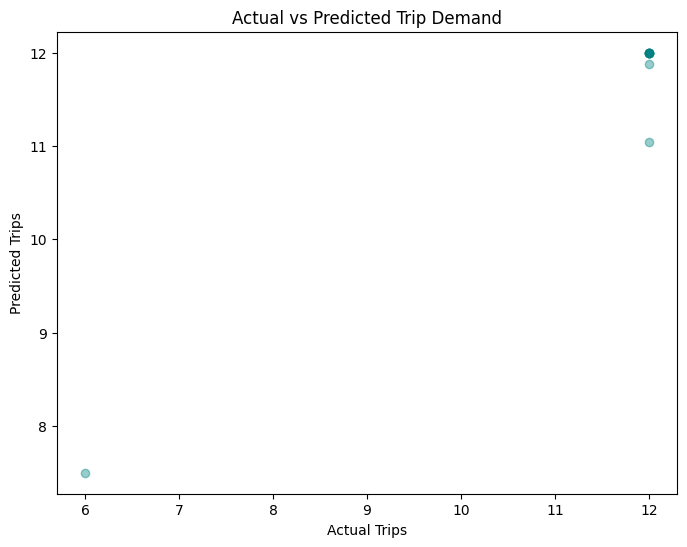

In [11]:
# 9️⃣ Visualization - Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4, color="teal")
plt.xlabel("Actual Trips")
plt.ylabel("Predicted Trips")
plt.title("Actual vs Predicted Trip Demand")
plt.show()



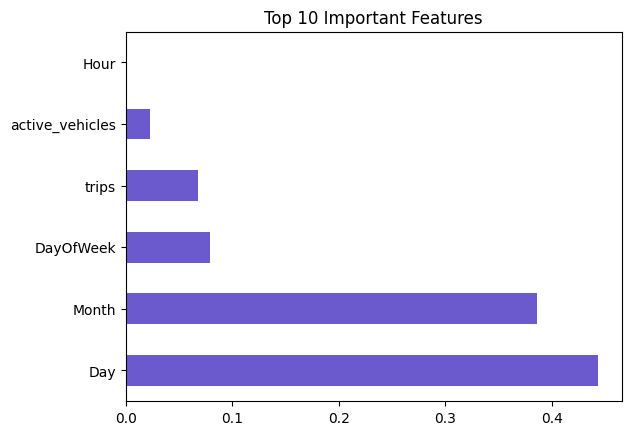

In [12]:
# 10️⃣ Feature Importance
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp.nlargest(10).plot(kind='barh', color='slateblue')
plt.title("Top 10 Important Features")
plt.show()